In [5]:
%matplotlib inline

import dateutil.parser
import datetime
import matplotlib.dates as mdates
import math as mt

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as pt

import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn as tflearn
from tensorflow.contrib import layers as tflayers

from sklearn.metrics import mean_squared_error

### Setting up number of training steps

In [6]:
tf.reset_default_graph()
TRAINING_STEPS = 10000
PRINT_STEPS = TRAINING_STEPS / 100

### Defining supporting data-transformation functions

In [7]:
def rnn_data(data, time_steps, labels=False):
       
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])

    return np.array(rnn_df, dtype=np.float32)

In [8]:
def split_data(data, val_size=0.1, test_size=0.1):
    
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test

In [9]:
def prepare_data(data, time_steps, labels=False, val_size=0.1, test_size=0.1):
       
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))

### Splitting data into train, cross-validation and test sets

In [10]:
def load_csvdata(x_rawdata, y_rawdata, time_steps, seperate=False):
    
    x_data = x_rawdata
    if not isinstance(x_data, pd.DataFrame):
        x_data = pd.DataFrame(x_data)
    y_data = y_rawdata
    if not isinstance(y_data, pd.DataFrame):
        y_data = pd.DataFrame(y_data)
        
    train_x, val_x, test_x = prepare_data(x_data['a'] if seperate else x_data, time_steps)
    train_y, val_y, test_y = prepare_data(y_data['b'] if seperate else y_data, time_steps, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

### Defining recurrent network based on stacked LSTM cells

In [11]:
def unstack_Xs(X, num_units, features_num):
    
    x_ = []
    x_temp = tf.unstack(X, axis=1, num=num_units)
    
    if (features_num > 1):
        xt1_ = []
        for x_i in x_temp:
            xu_i = tf.unstack(x_i, axis=1, num=features_num)
            for xu_ij in xu_i:
                xr_ij = tf.reshape(xu_ij, [-1, 1]) 
                x_.append(xr_ij)
    else:
        x_ = x_temp
    
    return x_

In [12]:
def lstm_model(time_steps, features_num, rnn_layers, dense_layers, learning_rate, optimizer):
    
    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(
                    layer['num_units'], state_is_tuple=True
                ),
                layer['keep_prob']
            ) if layer.get('keep_prob') else tf.contrib.rnn.BasicLSTMCell(
                    layer['num_units'],
                    state_is_tuple=True
                ) for layer in layers
            ]
        return [tf.contrib.rnn.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return tflayers.stack(input_layers, tflayers.fully_connected,
                                  layers['layers'],
                                  activation=layers.get('activation'),
                                  dropout=layers.get('dropout'))
        elif layers:
            return tflayers.stack(input_layers, tflayers.fully_connected, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.contrib.rnn.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = unstack_Xs(X, time_steps, features_num)       
        output, layers = tf.contrib.rnn.static_rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        prediction, loss = tflearn.models.linear_regression(output, y)
        train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(), optimizer=optimizer,
            learning_rate=learning_rate)
        return prediction, loss, train_op

    return _lstm_model

### Loading and plotting data

In [24]:
data = pd.read_csv('C:/Users/Oleg/Desktop/PEG_data.csv')
data['date_'] = data['date_'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date())
data = data.set_index('date_')

data['PEG_Return'] = np.log(data['PEG_Adj_Close'].shift(1)) - np.log(data['PEG_Adj_Close'].shift(2))
data['SP500_Return'] = np.log(data['SP500_Adj_Close'].shift(1)) - np.log(data['SP500_Adj_Close'].shift(2))

Variables = list(data)
for x in ['PEG_Close','PEG_Adj_Close','SP500_Close','SP500_Adj_Close']:
    Variables.remove(x)
data = data[Variables].dropna(axis=0, how='any')

Features = ['Natural_Gas', 'Coal_Price', 'Uranium_Price', 'VIX', 'UST_1y', 'UST_Slope', 'Electricity_NE_Price', 'Temperature', 'Wind_Speed', 'Precipitation']
X_data = data[Features]
Y_data = data['PEG_Return']

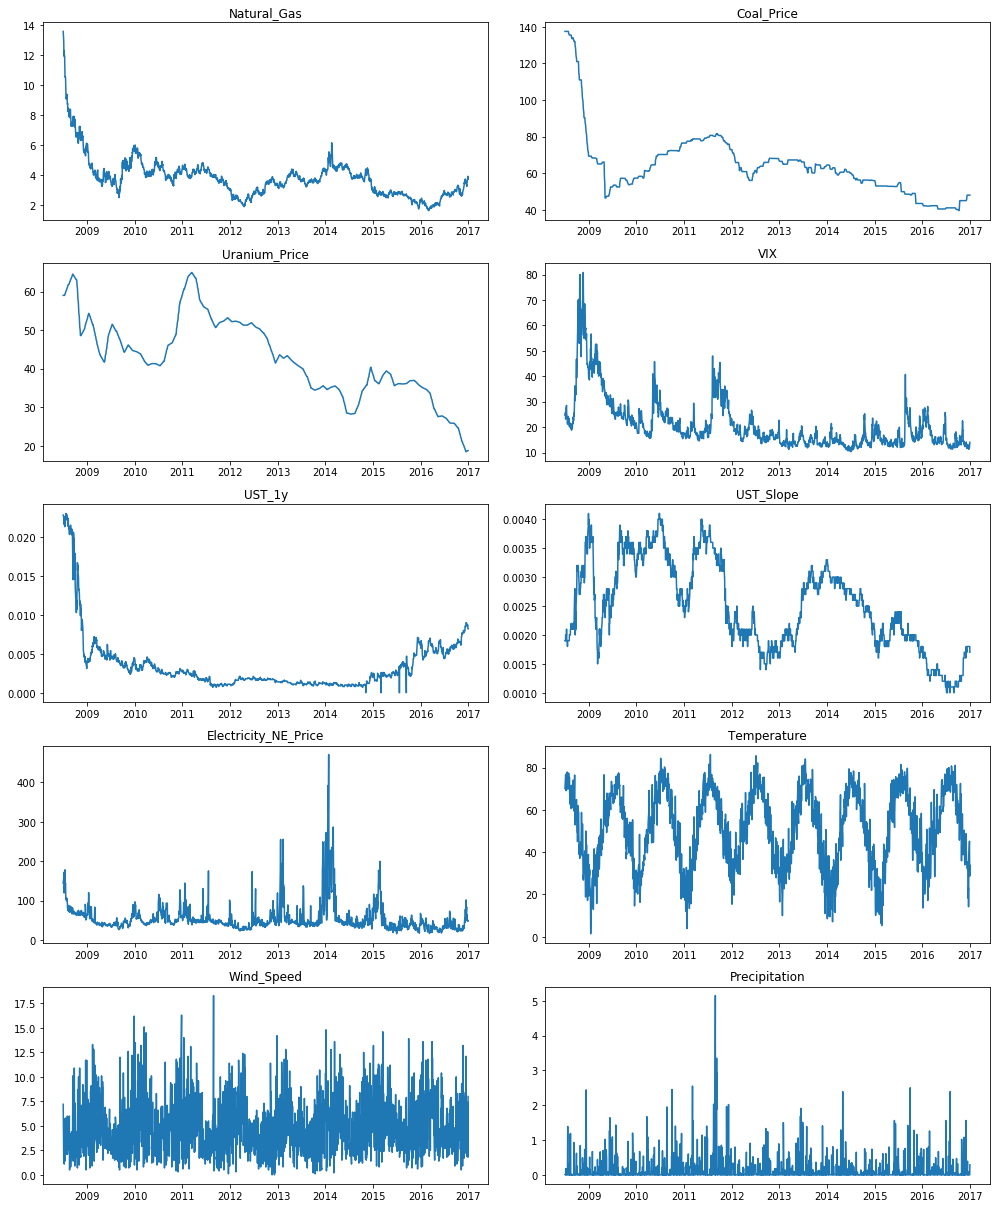

In [25]:
fg = pt.figure(figsize=(14,20))
for i in range(len(Features)):
    ax = fg.add_subplot(mt.floor(len(Features)/2)+1,2,i+1)
    ax.plot(data.index, data[Features[i]])
    ax.set_title(Features[i])
pt.tight_layout()
pt.show()

### Setting up configuration of network and optimization algorithm

In [27]:
SAMPLE_SIZE = len(pd.DataFrame(X_data))
FEATURES_NUM = len(pd.DataFrame(X_data).columns)

TIMESTEPS = 5
LSTM_LAYERS = 5
BATCH_SIZE = int(0.15 * (SAMPLE_SIZE - TIMESTEPS))

UNIT_NUM = FEATURES_NUM * TIMESTEPS
RNN_LAYERS = [{'num_units': UNIT_NUM} for i in range(LSTM_LAYERS)]
DENSE_LAYERS = [UNIT_NUM, UNIT_NUM]

X, y = load_csvdata(X_data, Y_data, TIMESTEPS, seperate=False)

In [28]:
regressor = tflearn.SKCompat(tflearn.Estimator(
    model_fn = lstm_model(
        TIMESTEPS,
        FEATURES_NUM,
        RNN_LAYERS,
        DENSE_LAYERS,
        learning_rate=0.1,
        optimizer='Adagrad'
    ),
    model_dir = None,
    config = None))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_tf_random_seed': None, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BA934C2A58>, '_model_dir': None, '_save_summary_steps': 100, '_environment': 'local', '_evaluation_master': '', '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_is_chief': True, '_keep_checkpoint_max': 5, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600}


### Training network with cross-validation

In [29]:
validation_monitor = tflearn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)

regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Oleg\AppData\Local\Temp\tmpoaixdnn4\model.ckpt.
INFO:tensorflow:loss = 0.107967, step = 1
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat

C:\Users\Oleg\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Starting evaluation at 2017-08-10-15:57:58
INFO:tensorflow:Restoring parameters from C:\Users\Oleg\AppData\Local\Temp\tmpoaixdnn4\model.ckpt-1
INFO:tensorflow:Finished evaluation at 2017-08-10-15:58:14
INFO:tensorflow:Saving dict for global step 1: global_step = 1, loss = 0.0076139
INFO:tensorflow:Validation (step 100): loss = 0.0076139, global_step = 1
INFO:tensorflow:global_step/sec: 0.527798
INFO:tensorflow:loss = 0.000260857, step = 101 (189.473 sec)
INFO:tensorflow:global_step/sec: 0.870293
INFO:tensorflow:loss = 0.00033365, step = 201 (114.899 sec)
INFO:tensorflow:global_step/sec: 0.620049
INFO:tensorflow:loss = 0.000442264, step = 301 (161.291 sec)
INFO:tensorflow:S

SKCompat()

### Calculating MSE on test dataset

In [30]:
predicted = regressor.predict(X['test'])
score = 100*mean_squared_error(predicted, y['test'])
print ("MSE: %f%%" % score)

Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Restoring parameters from C:\Users\Oleg\AppData\Local\Temp\tmpoaixdnn4\model.ckpt-2400
MSE: 0.013932%


### Plotting predictions on test dataset

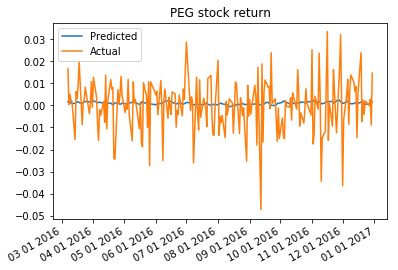

In [31]:
all_dates = data.index
fig, ax = pt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten() #already subset
predicted_dates = all_dates[len(all_dates)-len(predicted_values):len(all_dates)]
predicted_series = pd.Series(predicted_values, index=predicted_dates)
plot_predicted, = ax.plot(predicted_series, label='Predicted')

test_values = y['test'].flatten()
test_dates = all_dates[len(all_dates)-len(test_values):len(all_dates)]
test_series = pd.Series(test_values, index=test_dates)
plot_test, = ax.plot(test_series, label='Actual')

xfmt = mdates.DateFormatter('%m %d %Y')
ax.xaxis.set_major_formatter(xfmt)

pt.title('PEG stock return')
pt.legend(handles=[plot_predicted, plot_test])
pt.show()